## Content filtering using doc2vec

Basic, dumb version. Use all text related to a teacher i.e. essays, titles, categories etc. of projects posted to build a doc2vec vector and find similar teachers in that space. 

Tfidf weights are used to visualize some important words (there is a disconnect between tfidf & doc2vec but they words they pick up tend to be similar.

In [1]:
import os
import re
import random
import logging
import json
import csv
import string
from pprint import pprint
from collections import defaultdict

import gensim
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Paths to data files

In [2]:
# Data location
data_dir = "../../../data/"
models_dir = "../../../models/"
fname = "donorschooseorg_challenge_project.csv"

Read all the data into a dictionary (ideally shouldn't loaded into memory)

In [3]:
# Teacher dictionary is keyed by the teacher hash-id 
# Values are lists of projects posted
teachers = defaultdict(list)
with open(os.path.join(data_dir, fname)) as csvfile:
    # Read the csv record
    recreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    lc = 0
    for line in recreader:
        # Ignore the column header
        if lc == 0:
            lc+=1
            continue
        # Load the project attrs
        teacher_dict = { "title": line[2],
                        "essay1": line[3],
                        "essay2": line[4],
                        "school": line[14],
                        "posted_date": line[6],
                        "funded_date": line[7],
                        "project_id": line[1],
                        "subj_cat": line[9],
                        "subj_subcat": line[10],
                        "grade_cat": line[11],
                        "resc_type": line[12],
                       }
        # Append it to the teacher
        teachers[line[13]].append(teacher_dict)

### Create doc2vec embeddings

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# Strip punctuations
translator = str.maketrans('', '', string.punctuation)
# Clean up text and tokenize
def clean_and_tokenize(text):
    # Strip, lowercase & remove puncts
    text = text.strip().lower()
    text = text.translate(translator)
    text = text.split()
    return text

Class to create a document for each teacher

In [6]:
# Class to serve up tagged documents
class TeacherDocs(object):
    
    def __init__(self):
        pass
    
    def __iter__(self):
        # Open the project file
        for teacher in teachers:
            all_text = []
            for rec in teachers[teacher]:
                # Load the title & essays
                all_text += clean_and_tokenize(rec["title"])
                all_text += clean_and_tokenize(rec["essay1"])
                all_text += clean_and_tokenize(rec["essay2"])
                # Load the meta data by creating unique tokens from values
                all_text += ["_".join(rec["subj_cat"].strip().lower().split())]
                all_text += ["_".join(rec["subj_subcat"].strip().lower().split())]
                all_text += ["_".join(rec["grade_cat"].strip().lower().split())]
                all_text += ["_".join(rec["resc_type"].strip().lower().split())]
#             print((all_text, [teacher]))
#             break
            # Return all the text for the teacher
            yield gensim.models.doc2vec.TaggedDocument(all_text, [teacher])

Build out the model

In [25]:
# doc2vec params
window = 5
size = 100
iterations = 10

# bust_cache = True
bust_cache = False
model_path = os.path.join(models_dir, 'd2v_f-{}_s-{}_w-{}.model'.format(fname.split()[0],size, window))

# Build the model if it doesnt already exist
if not os.path.exists(model_path) or bust_cache:
    teacherlines = TeacherDocs() 
    model = gensim.models.doc2vec.Doc2Vec(size=size, min_count=5, window=window, iter=iterations,  workers=8)        
    model.build_vocab(teacherlines)
    model.train(teacherlines, total_examples=model.corpus_count, epochs=model.iter)
    model.save(model_path) 
else:
    model = gensim.models.doc2vec.Doc2Vec.load(model_path) 

2018-11-04 10:49:08,320 : INFO : loading Doc2Vec object from ../../../models/d2v_f-donorschooseorg_challenge_project.csv_s-100_w-5.model
2018-11-04 10:49:10,781 : INFO : loading vocabulary recursively from ../../../models/d2v_f-donorschooseorg_challenge_project.csv_s-100_w-5.model.vocabulary.* with mmap=None
2018-11-04 10:49:10,782 : INFO : loading trainables recursively from ../../../models/d2v_f-donorschooseorg_challenge_project.csv_s-100_w-5.model.trainables.* with mmap=None
2018-11-04 10:49:10,783 : INFO : loading wv recursively from ../../../models/d2v_f-donorschooseorg_challenge_project.csv_s-100_w-5.model.wv.* with mmap=None
2018-11-04 10:49:10,783 : INFO : loading docvecs recursively from ../../../models/d2v_f-donorschooseorg_challenge_project.csv_s-100_w-5.model.docvecs.* with mmap=None
2018-11-04 10:49:10,784 : INFO : loading vectors_docs from ../../../models/d2v_f-donorschooseorg_challenge_project.csv_s-100_w-5.model.docvecs.vectors_docs.npy with mmap=None
2018-11-04 10:49:1

### Create tf-idf word weights for visualization purposes

Load all the teacher ids & texts into two arrays

In [9]:
t = [] 
orig_docs = []
for teacher in teachers:
    t.append(teacher)
    all_text = []
    for rec in teachers[teacher]:
        # Load the title & essays
        all_text += clean_and_tokenize(rec["title"])
        all_text += clean_and_tokenize(rec["essay1"])
        all_text += clean_and_tokenize(rec["essay2"])
        # Load the meta data by creating unique tokens from values
        all_text += ["_".join(rec["subj_cat"].strip().lower().split())]
        all_text += ["_".join(rec["subj_subcat"].strip().lower().split())]
        all_text += ["_".join(rec["grade_cat"].strip().lower().split())]
        all_text += ["_".join(rec["resc_type"].strip().lower().split())]

    orig_docs.append(" ".join(all_text))

In [10]:
# Use only unigrams since doc2vec is operating on unigram tokens
vectorizer = TfidfVectorizer(stop_words=u'english', ngram_range=(1,1), max_features=25000)
# Transform the input features
docs = vectorizer.fit_transform(orig_docs)

Functions to get word weights per document

In [11]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

Word cloud plotting

In [12]:
# Global configuration for matplotlib figures
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.facecolor'] = '#FFFFFF00'
plt.rcParams['axes.facecolor'] = '#FF00000F'

In [13]:
# Load the feature names
# you only needs to do this once, this is a mapping of index to 
feature_names=vectorizer.get_feature_names()

In [14]:
def show_wc(teacher_index, print_words=True):
    # Word cloud
    wc = WordCloud(background_color="white", max_words=2000, width = 2048,height = 720)
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(docs[teacher_index].tocoo())
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    if print_words:
        print("\n===Keywords===")
        for k in keywords:
            print(k,keywords[k])
    keywords=extract_topn_from_vector(feature_names,sorted_items,100)
    weights = {k: keywords[k] for k in keywords}
    wc.generate_from_frequencies(weights)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Load the model, generate random recommendations and visualize

First pick a random teacher as an anchor

In [15]:
random_teacher = random.choice(list(teachers.keys()))

print("--- Current logged in teacher (anchor) ---")
print("Teacher id: {}".format(random_teacher))
# Print all the projects
for i in range(len(teachers[random_teacher])):
    print(" ---- Project num - {} ----".format(i+1))
    print("Project Id: {}".format(teachers[random_teacher][i]["project_id"]))
    print("School: {}".format(teachers[random_teacher][i]["school"]))
    print("Posted: {}".format(teachers[random_teacher][i]["posted_date"]))
    print("Funded: {}".format(teachers[random_teacher][i]["funded_date"]))
    print("Grade : {}".format(teachers[random_teacher][i]["grade_cat"]))
    print("Subj  : {}".format(teachers[random_teacher][i]["subj_cat"]))
    print("-- free text --")
    print("Title: {}".format(teachers[random_teacher][i]["title"]))
    print("Essay1: {}".format(teachers[random_teacher][i]["essay1"]))
    print("Essay2: {}".format(teachers[random_teacher][i]["essay2"]))
    print(" ---- End of project - {} ----".format(i))

--- Current logged in teacher (anchor) ---
Teacher id: 1975333ed169dd016cb3007017ca1bc0
 ---- Project num - 1 ----
Project Id: ffa2a8757ea5d86a6063361594369e83
School: 3861d10883abdda813bbf7856b901bab
Posted: 2018-06-20
Funded: 2018-07-24
Grade : Grades 3-5
Subj  : Literacy & Language, Special Needs
-- free text --
Title: Fueling Students With Flexible Seating Options
Essay1: my classroom is composed of 24 amazing students.  our school is set in a rural, farming community in indiana. at our school, we strive to do the right thing, treat people right, and love to learn. we focus on life skills such as honesty, perseverance, and integrity, as well as the core subjects of reading, math, science, and social studies. my students are problem solvers and always up for a challenge! they love to work together on projects and activities. it’s important to me that my students lead our classroom. they help make decisions and guide our classroom learning.
Essay2: flexible seating allows students to

Visualize the word cloud for the teacher


===Keywords===
students 0.21
core 0.208
plastic 0.178
options 0.178
work 0.176
seating 0.154
fueling 0.143
honesty 0.14
noticeably 0.138
stools 0.137


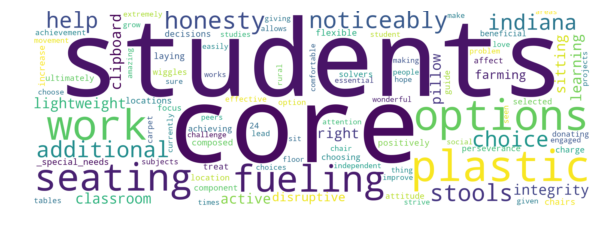

In [16]:
show_wc(t.index(random_teacher))

Next load the similar items

In [17]:
# Load top 3 most similar by content. Ignore the first cos its the same teacher
top = 3
sim_teachers = model.docvecs.most_similar(random_teacher, topn=top+1)[1:] 

2018-11-04 10:44:06,186 : INFO : precomputing L2-norms of doc weight vectors
/Users/a0k00j8/.virtualenvs/donors/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Print out top3 recommendations one by one (to keep visuals without the need to scroll)

Rank - 1
Id - dd6c173405c00d256a2033dab79b85e2
 Score - 0.8340075016021729
 ---- Project num - 1 ----
Project Id: 84c532c5e78b63a344ae8ef0b0adc908
School: 7490e979843f94182c6b2cb145428ee7
Posted: 2018-06-16
Funded: 2018-06-22
Grade : Grades PreK-2
Subj  : Literacy & Language, Math & Science
-- free text --
Title: Flexible Seating for My Future Learners! 
Essay1: i am a second grade teacher with a goal of making a difference in our future!  our school strives to find the leader in all students. every child has their own set of capabilities, talents, and strengths. in my classroom, we strive to push ourselves outside our comfort zone. we are a team and take care of each other. we work to help each other improve throughout the year!
my students show me their love of learning every day, and i am always looking for new ways to help them grow and showcase their passions in and out of the classroom. 

Essay2: flexible seating allows students to take charge of their learning and make the choic

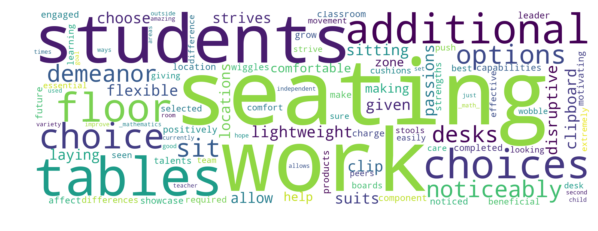

In [18]:
c = 0
sim_teacher, sim_score = sim_teachers[c]
print("Rank - {}\nId - {}\n Score - {}".format(c+1, sim_teacher, sim_score))
for i in range(len(teachers[sim_teacher])):
    print(" ---- Project num - {} ----".format(i+1))
    print("Project Id: {}".format(teachers[sim_teacher][i]["project_id"]))
    print("School: {}".format(teachers[sim_teacher][i]["school"]))
    print("Posted: {}".format(teachers[sim_teacher][i]["posted_date"]))
    print("Funded: {}".format(teachers[sim_teacher][i]["funded_date"]))
    print("Grade : {}".format(teachers[sim_teacher][i]["grade_cat"]))
    print("Subj  : {}".format(teachers[sim_teacher][i]["subj_cat"]))
    print("-- free text --")
    print("Title: {}".format(teachers[sim_teacher][i]["title"]))
    print("Essay1: {}".format(teachers[sim_teacher][i]["essay1"]))
    print("Essay2: {}".format(teachers[sim_teacher][i]["essay2"]))
    print(" ---- End of project - {} ----".format(i))
show_wc(t.index(sim_teacher))

Rank - 2
Id - 585ae76c0f02f98ce04a9ca87daae57f
 Score - 0.8296658396720886
 ---- Project num - 1 ----
Project Id: eb2a9c11ce2bcf3617100306e02229e7
School: 672d0c34469fe974880eae70fdb853d1
Posted: 2018-04-11
Funded: 
Grade : Grades 3-5
Subj  : Health & Sports
-- free text --
Title: Sit, Spin, and Learn
Essay1: my fifth grade students are amazing problem solvers who benefit greatly from flexible seating in our classroom.   we are located  in  a suburban school in the midwest.   my students come from varied cultures and backgrounds.
to meet the needs of my students,  i try to create a classroom environment that allows  students to learn while allowing them to move enough to use their excess energy.  studies show that children learn best when they have options for their learning environment.    my energetic fifth graders focus best when they are allowed the flexibility to choose a learning environment  that fits their individual needs.
Essay2: to help students learn while using up excess e

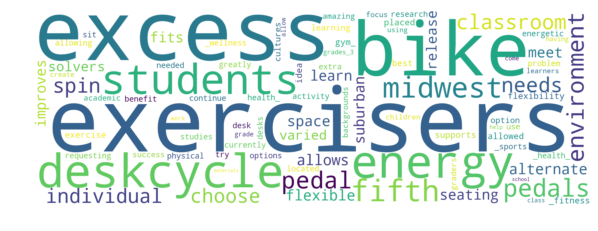

In [19]:
c = 1
sim_teacher, sim_score = sim_teachers[c]
print("Rank - {}\nId - {}\n Score - {}".format(c+1, sim_teacher, sim_score))
for i in range(len(teachers[sim_teacher])):
    print(" ---- Project num - {} ----".format(i+1))
    print("Project Id: {}".format(teachers[sim_teacher][i]["project_id"]))
    print("School: {}".format(teachers[sim_teacher][i]["school"]))
    print("Posted: {}".format(teachers[sim_teacher][i]["posted_date"]))
    print("Funded: {}".format(teachers[sim_teacher][i]["funded_date"]))
    print("Grade : {}".format(teachers[sim_teacher][i]["grade_cat"]))
    print("Subj  : {}".format(teachers[sim_teacher][i]["subj_cat"]))
    print("-- free text --")
    print("Title: {}".format(teachers[sim_teacher][i]["title"]))
    print("Essay1: {}".format(teachers[sim_teacher][i]["essay1"]))
    print("Essay2: {}".format(teachers[sim_teacher][i]["essay2"]))
    print(" ---- End of project - {} ----".format(i))
show_wc(t.index(sim_teacher))

Rank - 3
Id - d2434ca691065337938be26f4695050d
 Score - 0.829504668712616
 ---- Project num - 1 ----
Project Id: 2854821ee78e3d0a516538ef048c557f
School: 27388f19d448cfcb9ebc481201c7eb33
Posted: 2018-06-19
Funded: 
Grade : Grades 3-5
Subj  : Health & Sports, Music & The Arts
-- free text --
Title: Have a Seat...Anywhere!
Essay1: my students are creative, thoughtful and full of questions! they absolutely love hands-on, active, engaging projects and challenges that allow them to think outside the box to find solutions! they come to school each day ready to try new things and take brave chances in order to grow both personally and academically. truly, they are my inspiration!


each child in my classroom absolutely loves learning, although the method and environment in which they learn best vary greatly. we incorporate a variety of learning strategies, group work, and alternative seating and learning options to ensure that each student's needs are met, right where they are! they are truly

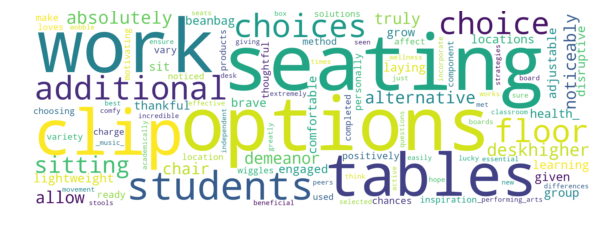

In [20]:
c = 2
sim_teacher, sim_score = sim_teachers[c]
print("Rank - {}\nId - {}\n Score - {}".format(c+1, sim_teacher, sim_score))
for i in range(len(teachers[sim_teacher])):
    print(" ---- Project num - {} ----".format(i+1))
    print("Project Id: {}".format(teachers[sim_teacher][i]["project_id"]))
    print("School: {}".format(teachers[sim_teacher][i]["school"]))
    print("Posted: {}".format(teachers[sim_teacher][i]["posted_date"]))
    print("Funded: {}".format(teachers[sim_teacher][i]["funded_date"]))
    print("Grade : {}".format(teachers[sim_teacher][i]["grade_cat"]))
    print("Subj  : {}".format(teachers[sim_teacher][i]["subj_cat"]))
    print("-- free text --")
    print("Title: {}".format(teachers[sim_teacher][i]["title"]))
    print("Essay1: {}".format(teachers[sim_teacher][i]["essay1"]))
    print("Essay2: {}".format(teachers[sim_teacher][i]["essay2"]))
    print(" ---- End of project - {} ----".format(i))
show_wc(t.index(sim_teacher))

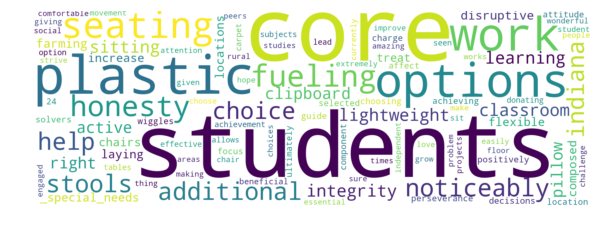

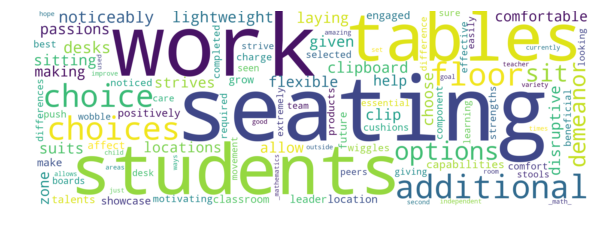

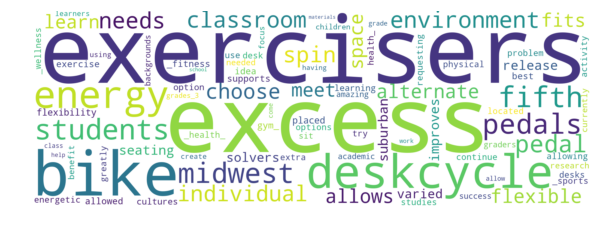

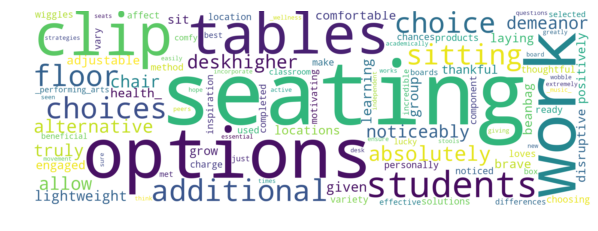

In [21]:
show_wc(t.index(random_teacher), print_words=False)
show_wc(t.index(sim_teachers[0][0]), print_words=False)
show_wc(t.index(sim_teachers[1][0]), print_words=False)
show_wc(t.index(sim_teachers[2][0]), print_words=False)

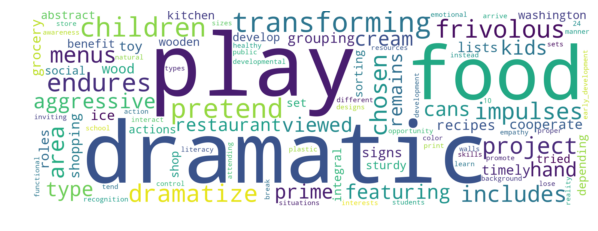

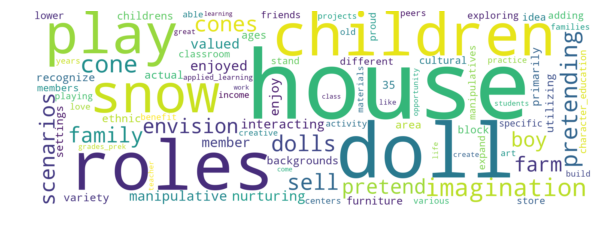

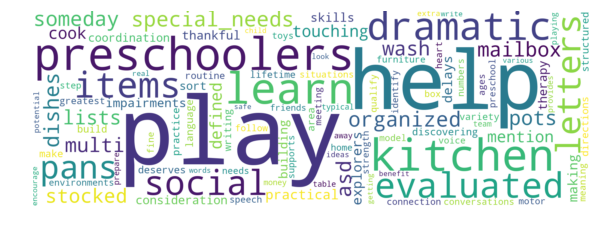

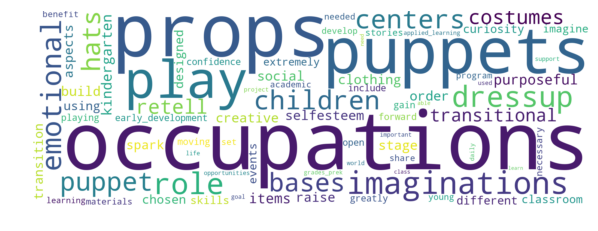

In [22]:
random_teacher = random.choice(list(teachers.keys()))
top = 3
sim_teachers = model.docvecs.most_similar(random_teacher, topn=top+1)[1:] 
show_wc(t.index(random_teacher), print_words=False)
show_wc(t.index(sim_teachers[0][0]), print_words=False)
show_wc(t.index(sim_teachers[1][0]), print_words=False)
show_wc(t.index(sim_teachers[2][0]), print_words=False)

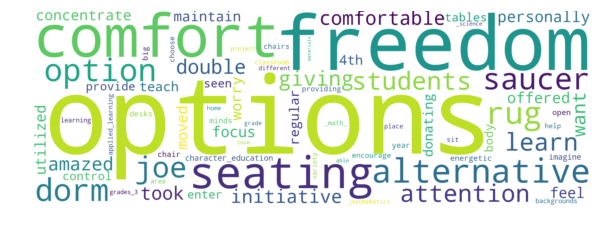

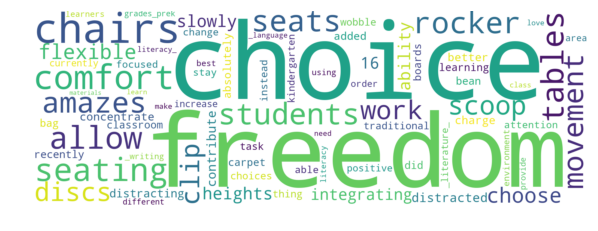

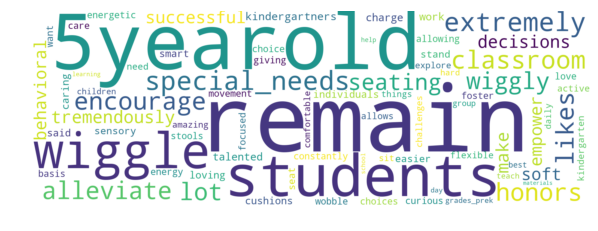

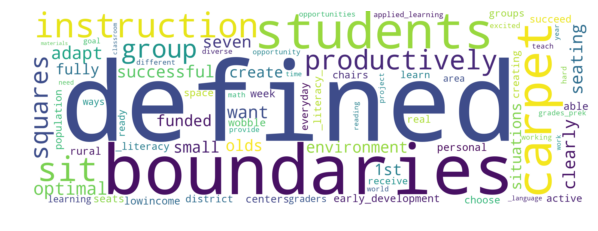

In [23]:
random_teacher = random.choice(list(teachers.keys()))
top = 3
sim_teachers = model.docvecs.most_similar(random_teacher, topn=top+1)[1:] 
show_wc(t.index(random_teacher), print_words=False)
show_wc(t.index(sim_teachers[0][0]), print_words=False)
show_wc(t.index(sim_teachers[1][0]), print_words=False)
show_wc(t.index(sim_teachers[2][0]), print_words=False)

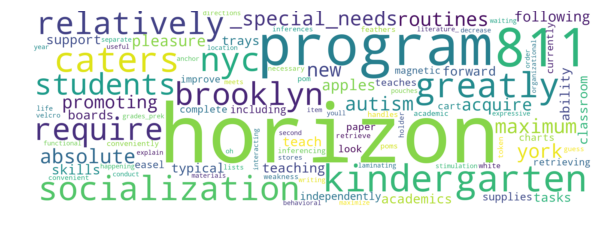

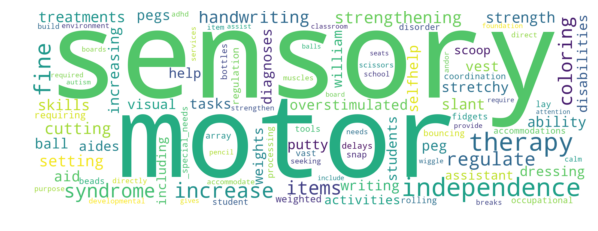

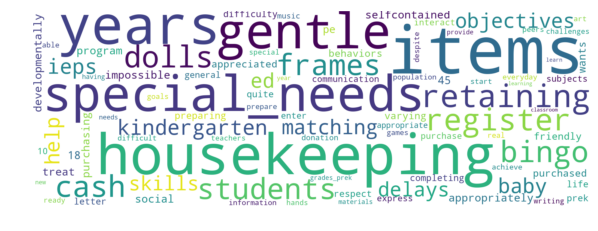

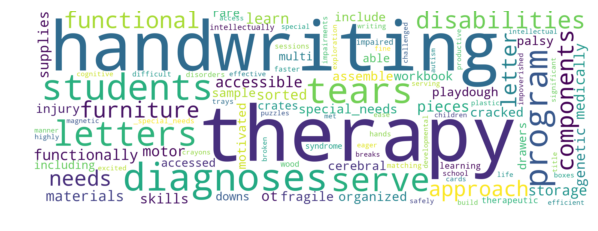

In [24]:
random_teacher = random.choice(list(teachers.keys()))
top = 3
sim_teachers = model.docvecs.most_similar(random_teacher, topn=top+1)[1:] 
show_wc(t.index(random_teacher), print_words=False)
show_wc(t.index(sim_teachers[0][0]), print_words=False)
show_wc(t.index(sim_teachers[1][0]), print_words=False)
show_wc(t.index(sim_teachers[2][0]), print_words=False)